# Response of the chemical potential $\mu$ to the Zeeman energy $E_Z$

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize
import logging
import cPickle as pickle
import kwant
import dolfin
import electrostatics as estat
import generate_system
logging.getLogger('FFC').setLevel(logging.WARNING)

In [3]:
"""Set system dimensions and constants"""

hbar = 1.055e-34
m = 9.109e-31
meff = 0.014*m
akwant, aFEM = 2.5e-9, 5e-9
eV, e = 1.6023e-19, 1.6023e-19
eps0 = 8.854e-12
gamma=hbar**2/(2*meff*akwant**2)
energy_par = estat.EnergyParameters(akwant=akwant, eps_dielec=8.0, eps_wire=17.7, 
                                    gamma=hbar**2/(2*meff*akwant**2),
                                    scaler=eV/gamma, bandgap=0.1, Delta=0.5e-3, 
                                    poisson_scale=e*aFEM**2/(akwant**3*eps0),
                                    miliscaler = 1000*gamma/eV)

dimension_par = estat.DimensionParameters(radius=50e-9/aFEM, top=250e-9/aFEM,
                                          top_sc=187e-9/aFEM - 10*np.sin(np.pi/3.0),
                                          side=300e-9/aFEM, dielec_thickness=30e-9/aFEM)
solver_kwargs = {'alpha': 0.5, 'M': 5, 'verbose': 0, 'f_tol': 1e-7, 'maxiter': 200} 

environment_parameters = [{'V_G': 0.112, 'V_SC': 'No SC', 'l_SO': 233e-9, 'tag': 'No SC'},
                          {'V_G': 0.3011, 'V_SC': 0.0, 'l_SO': 233e-9, 'tag': '0V, 233nm'},
                          {'V_G': -0.91, 'V_SC': 0.2, 'l_SO': 233e-9, 'tag': '02V, 233nm'},
                          {'V_G': 0.3042, 'V_SC': 0.0, 'l_SO': 100e-9, 'tag': '0V, 100nm'},
                          {'V_G': -0.903, 'V_SC': 0.2, 'l_SO': 100e-9, 'tag': '02V, 100nm'},
                          {'V_G': 0.3085, 'V_SC': 0.0, 'l_SO': 60e-9, 'tag': '0V, 60nm'},
                          {'V_G': -0.893, 'V_SC': 0.2, 'l_SO': 60e-9, 'tag': '02V, 60nm'}]

## Response of chemical potential and density to variation in $E_Z$

In [12]:
sys = generate_system.kwant_hexagonal_nanowire(energy_par, dimension_par, a=0.5)
site_pos = np.array([sys.site(i).pos for i in xrange(sys.graph.num_nodes)])
mesh, mesh_points, length, length_wire = generate_system.mesh_hexagonal_nanowire(dimension_par)[:4]
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
discr_par = estat.DiscretizationParameters(sys=sys, site_pos=site_pos, mesh=mesh, 
                                           mesh_points=mesh_points, length=length, 
                                           length_wire=length_wire, V=V)

Ez_range = np.arange(0.0e-3*eV/gamma, 7.3e-3*eV/gamma, 0.01e-3*eV/gamma)
mu_pert_dict = {}
dn_dict = {}
P_dict = {}

for environment in environment_parameters:
    V_G = environment['V_G']
    V_SC = environment['V_SC']
    bound_conds = estat.BoundaryParameters(V_G=V_G, V_SC=V_SC)
    l_SO = environment['l_SO']
    alpha = energy_par.akwant/l_SO
    initial_guess = 0.06*np.ones(discr_par.length)
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    perturbations, mu0, wave_modes, densities, sp_sol, energies =\
    estat.init_field_simulation(0e-3*eV/gamma, initial_guess, sigma, l_SO, V_G, V_SC, 
                                generate_system.potential, solver_kwargs, energy_par, 
                                dimension_par, discr_par)[:6]
    dmu_init = np.zeros(len(energies))
    wf0 = wave_modes[-1]
    n0 = densities[-1]
    mu_pert_list = []
    dn_list = []
    P_list = []
    
    for Ez in Ez_range:
        mu_pert, P, alpha_func, dn = estat.self_consistent_mu(wave_modes, energies, 
                                                              densities, perturbations,
                                                              Ez, l_SO, dmu_init, V_G, 
                                                              energy_par)[0:4]
        dmu_init = mu_pert
        mu_pert_list.append(mu0 - mu_pert[-1])
        dn_list.append(dn)
        P_list.append(P)
    mu_pert_dict[environment['tag']] = mu_pert_list
    dn_dict[environment['tag']] = dn_list
    P_dict[environment['tag']] = P_list

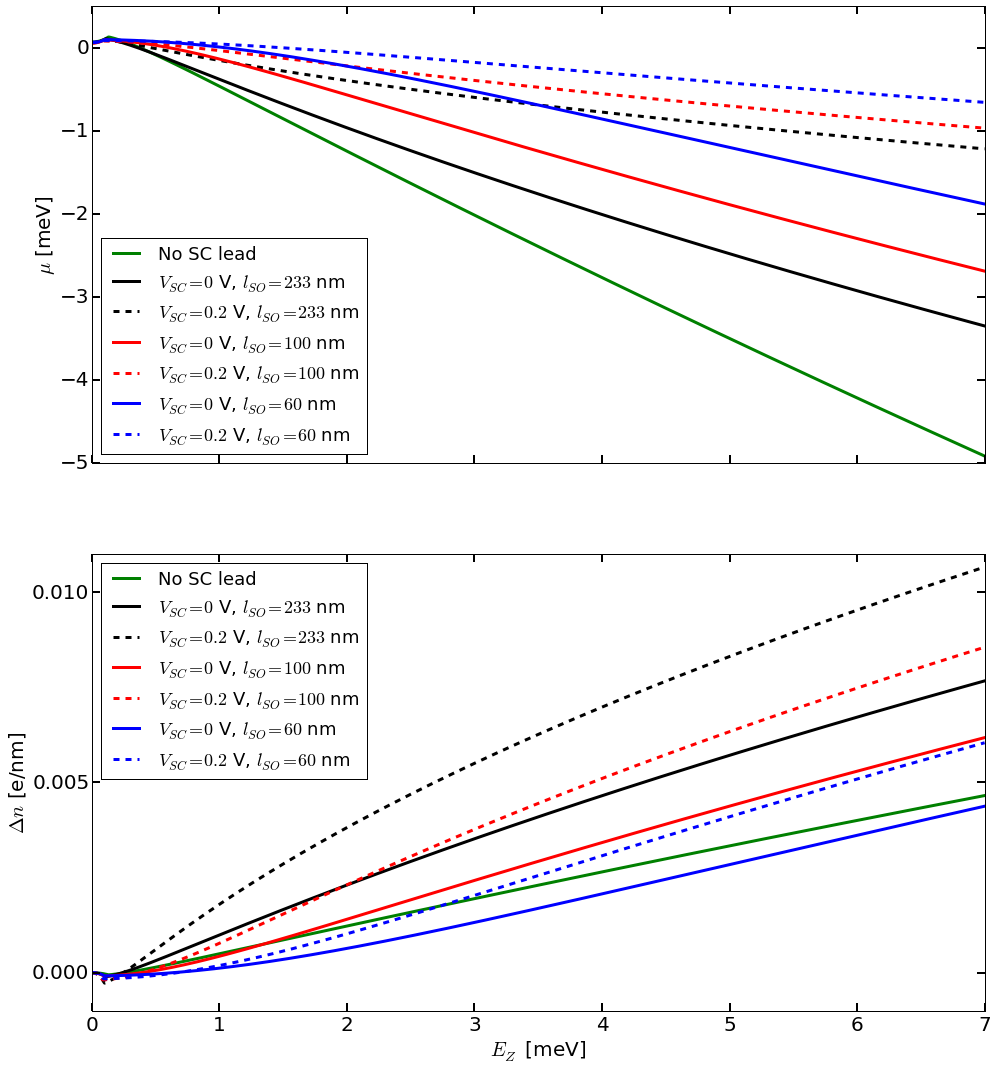

In [5]:
kw_str = ['No SC', '0V, 233nm', '02V, 233nm', '0V, 100nm', 
          '02V, 100nm', '0V, 60nm', '02V, 60nm']
title_str = ['No SC lead', '$V_{SC} = 0$ V, $l_{SO} = 233$ nm', 
             '$V_{SC} = 0.2$ V, $l_{SO} = 233$ nm',
             '$V_{SC} = 0$ V, $l_{SO} = 100$ nm', 
             '$V_{SC} = 0.2$ V, $l_{SO} = 100$ nm',
             '$V_{SC} = 0$ V, $l_{SO} = 60$ nm',
             '$V_{SC} = 0.2$ V, $l_{SO} = 60$ nm']
clr_str = ['g-', 'k-', 'k--', 'r-', 'r--', 'b-', 'b--']

Ez_range_scaled = [1000*gamma/eV*a for a in Ez_range]

fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(2, 1, 1)
ax1.hold(True)
for i, kw in enumerate(kw_str):
    mu_pert_arr_scaled = 1000*gamma/eV*np.array(mu_pert_dict[kw])
    ax1.plot(Ez_range_scaled, mu_pert_arr_scaled, clr_str[i], 
             label=title_str[i], lw=3)
ax1.set_ylabel('$\mu$ [meV]', fontsize=20)
ax1.legend(loc='lower left', ncol=1, fontsize=18)
ax1.locator_params(axis = 'y', nbins=6)
plb.setp(ax1.get_xticklabels(), visible=False)
ax1.set_xlim(0, 7)
ax1.set_ylim(-5, 0.5)
ax1.tick_params(width=2, size=8, labelsize=20)

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.hold(True)
for i, kw in enumerate(kw_str):
    ax2.plot(Ez_range_scaled, 1/2.5*np.array(dn_dict[kw]), clr_str[i], 
             label=title_str[i], lw=3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
ax2.set_xlabel('$E_Z$ [meV]', fontsize=20)
ax2.set_ylabel('$\Delta n$ [e/nm]', fontsize=20)
ax2.locator_params(axis = 'y', nbins=5)
ax2.legend(loc='upper left', ncol=1, fontsize=18)
ax2.set_xlim(0, 7)
ax2.set_ylim(-0.001, 0.011)
ax2.tick_params(width=2, size=8, labelsize=20)

In [5]:
with open("data_mu_single_band.p", 'wb') as fp:
    pickle.dump(Ez_range, fp)
    pickle.dump(mu_pert_dict, fp)
    pickle.dump(dn_dict, fp)